### Desafío - Regularización

**Nombre alumno: Nicolás Gómez**

Profesor: Gabriel Tamayo L.

Generación: G2

Para realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
Una vez terminado el desafío, comprime la carpeta y sube el .zip a la sección
correspondiente.


#### Descripción
En esta ocasión utilizaremos datos de la composición química de muestras de vino.

Nuestro propósito será tratar de predecir su calidad a partir de su composición química.

Comience su estudio realizando un breve análisis exploratorio y descriptivo:
* Identifique el tipo de datos de cada columna.
* Identifique outliers univariados y multivariados. Los primeros los puede encontrar realizando boxplots de cada atributo, los segundos estudiando los scatterplot entre pares de atributos.
* Encuentre la cantidad de valores faltantes en cada columna.
* Grafique la distribución empírica de cada atributo.

### Ejercicio 1: Preparación del Ambiente de Trabajo
* Importe las librerías básicas
* Importe los métodos asociados a regularización
* Importe la base de datos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error

warnings.filterwarnings(action='ignore')
plt.rcParams["figure.figsize"] = (20, 15)
plt.rcParams["figure.dpi"] = 80
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('winequality-red.csv')
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


### Ejercicio 2: Análisis exploratorio
* Identifique el tipo de datos de cada columna.
* Identifique outliers univariados y multivariados. Los primeros los puede encontrar realizando boxplots de cada atributo, los segundos estudiando los scatterplot entre pares de atributos.

#### Tipos de datos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


#### Outliers univariados

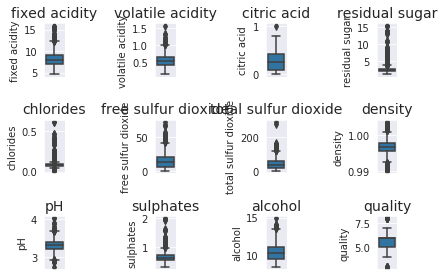

In [4]:
ncols = 4
nrows = int(np.ceil(len(df.columns) / ncols))

fig, ax = plt.subplots(nrows, ncols)
n = 0

for col_name, col in df.iteritems():
    sns.boxplot(col, orient='v', ax=ax[n // ncols, n % ncols]).set_title(col_name, size=14)
    n += 1

plt.tight_layout()

Aquí podemos ver que todos los atributos tienen outliers, sobre todo las siguientes:

- residual_sugar
- fixed_acidity
- sulphatos
- chlorides

Para las multivariadas, utilizaré un pairplot para ver a grandes rasgos el comportamiento:

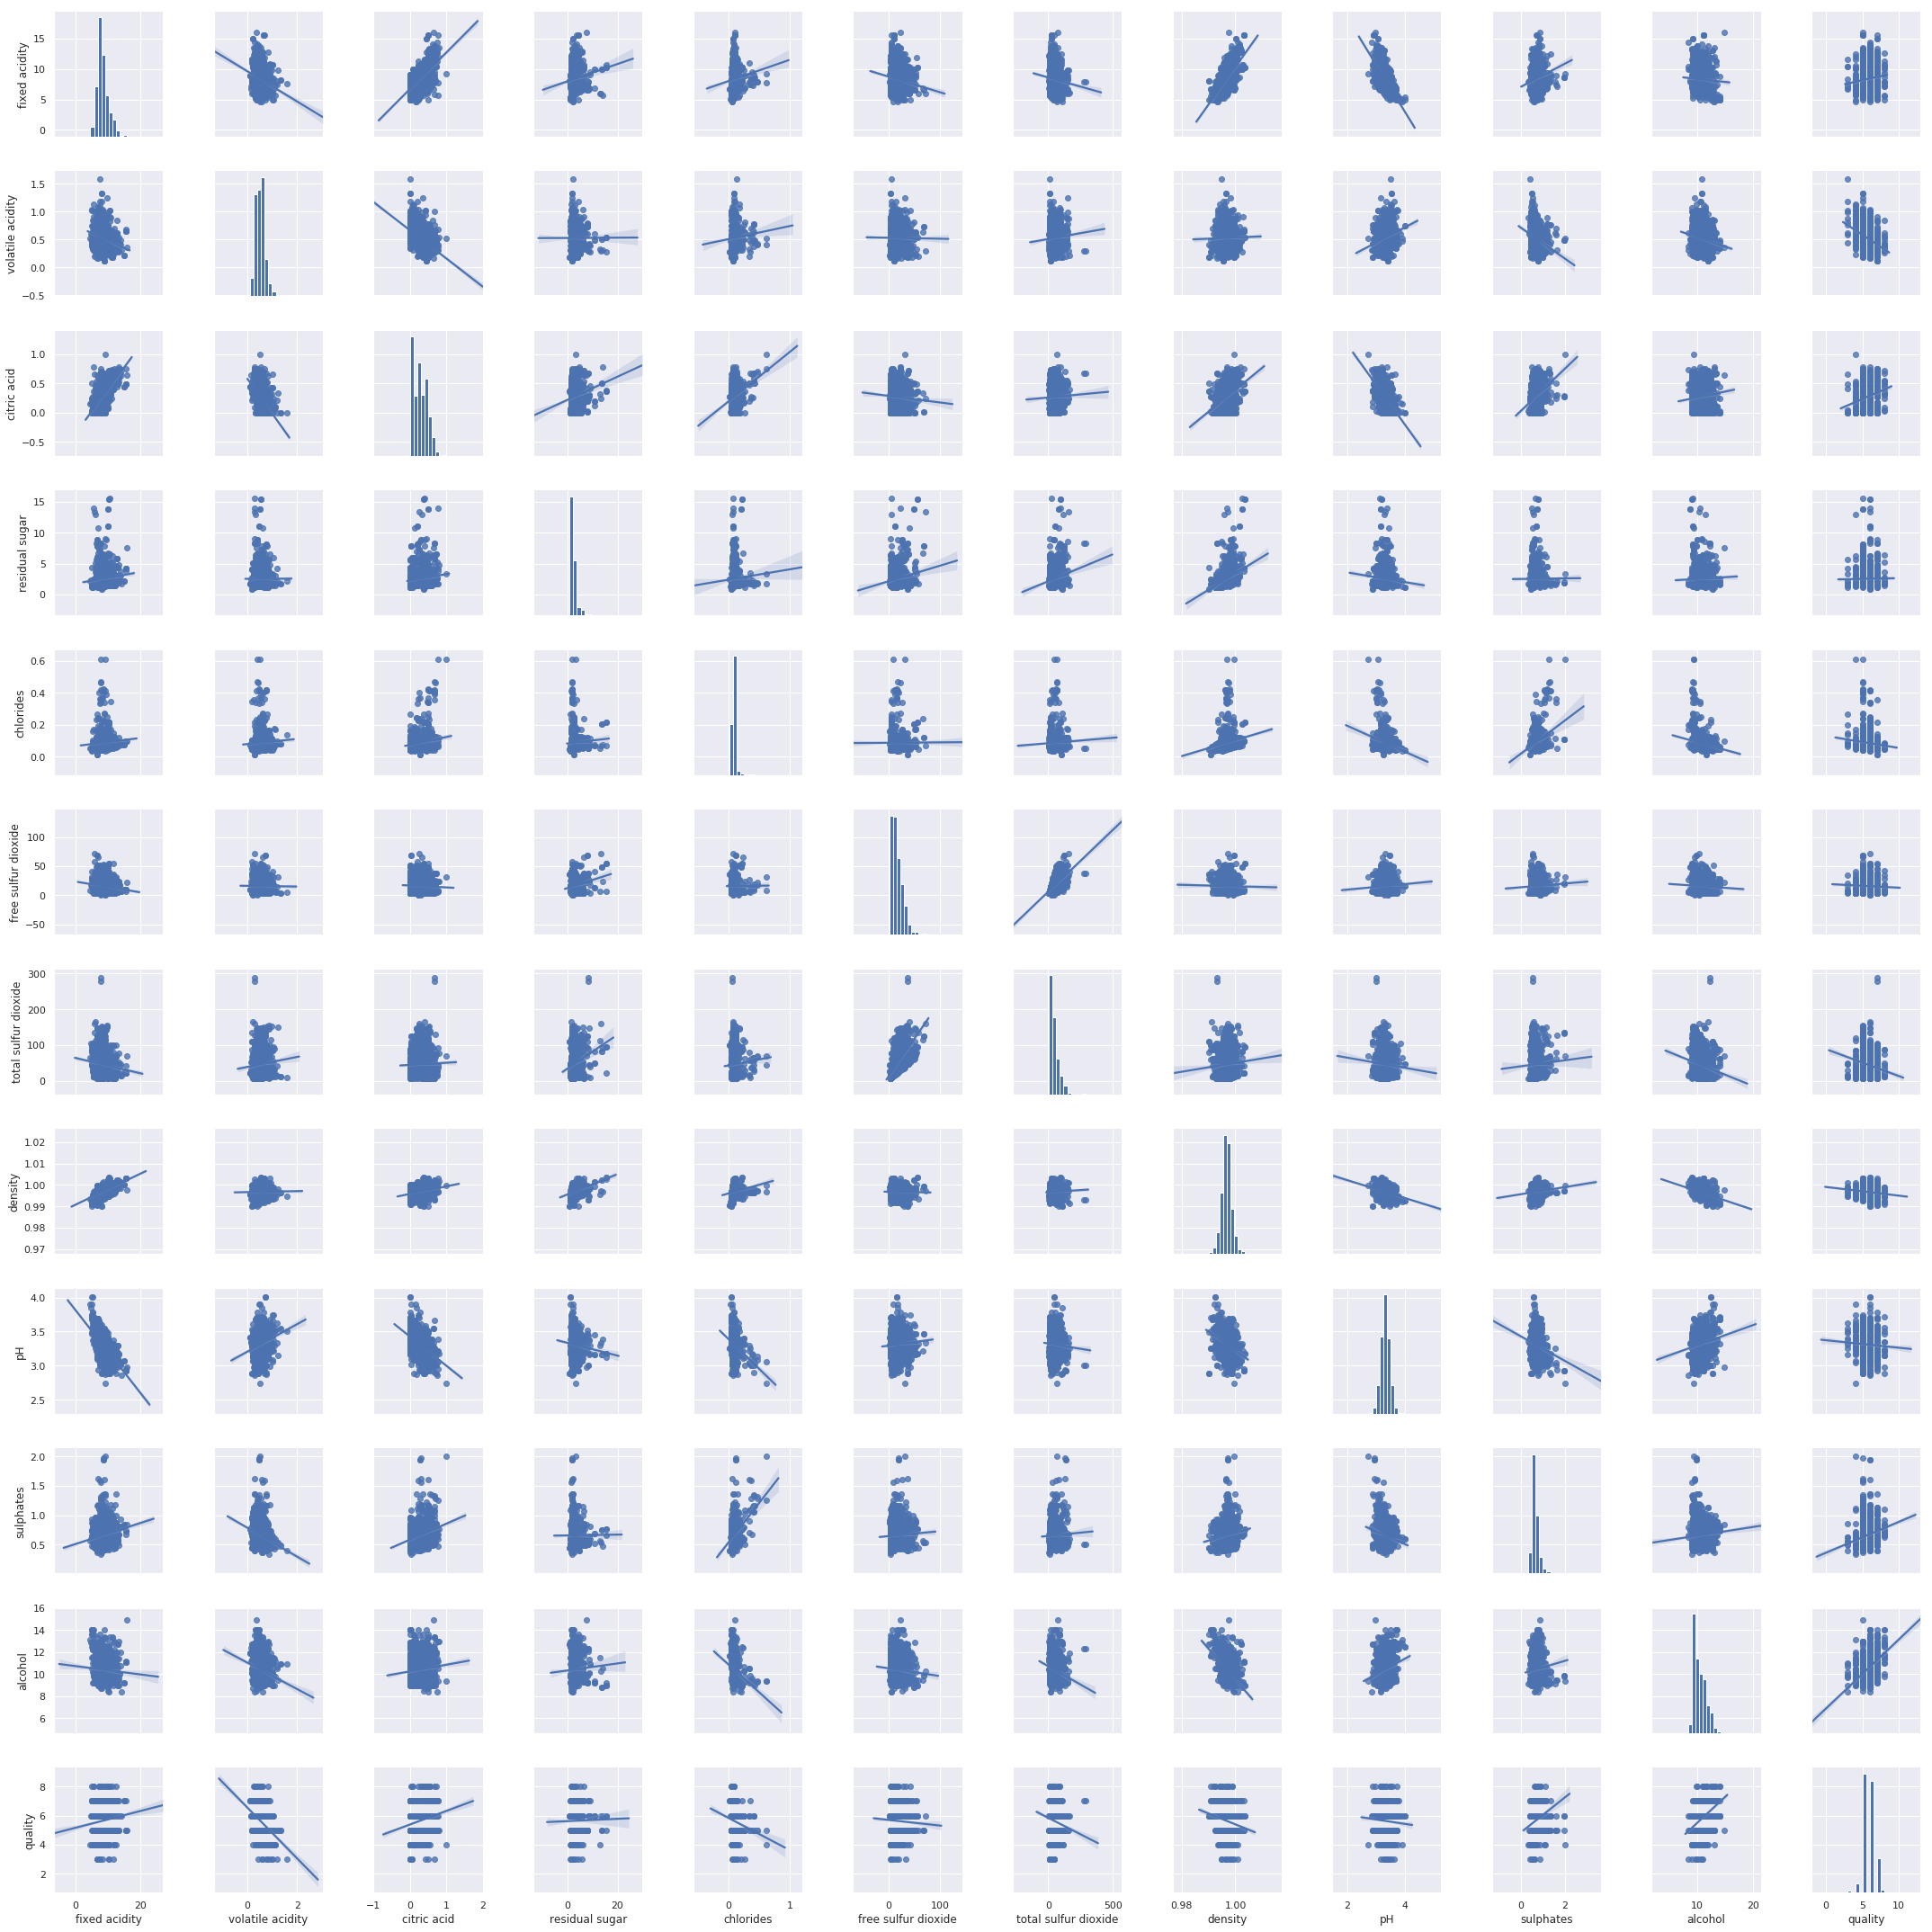

In [5]:
sns.set(rc={'figure.figsize':(30,30)})
sns.pairplot(df, kind='reg');
plt.tight_layout()

**Observaciones**:

- `fixed acidity`, `citric acid`, `total sulfur dioxide`, `pH`, `sulphates` tiene correlaciones distintas de 0 con gran cantidad de otras variables
- `quality`, que es el vector objetivo, varía con casi todas, excepto con `redidual sugar` (la pendiente es casi horizontal)

### Ejercicio 3: Regularización de modelos
Genere tres modelos, correspondientes a RidgeCV , LassoCV y ElasticNetCV . Para cada uno de ellos implemente los siguientes pasos:
* Entrene los modelos con 10 validaciones cruzadas.
* Extraiga los coeficientes estimados, el mejor valor alpha, MAE (median_absolute_error) y RMSE (mean_squared_error) asociado a cada modelo.

En base a la información solicitada, responda lo siguiente:
* ¿Qué modelo presenta un mejor desempeño en base a las métricas?
* ¿Qué atributos mantienen un comportamiento similar a lo largo de cada modelo?

Sobre los métodos RidgeCV , LassoCV y ElasticNetCV
* Para implementar la búsqueda de hiperparámetros con validación cruzada, utilizaremos la clase sklearn.linear_model.{RidgeCV, LassoCV, ElasticNetCV} .
* Por defecto, la clase necesita de una lista de valores alphas que representa el hiperparámetro de validación. Si no se define la lista, el método incorporará un array con valores por defecto.
* Por defecto la clase tendrá una opción scoring que permitirá definir la métrica con la cual se evaluará el mejor hiperparámetro. Para el caso de un problema de regresión, si no se define, la métrica será el error cuadrático promedio negativo (más alto es mejor).
* Una vez entrenado el modelo, se puede reportar el mejor alpha con modelo_entrenado.alpha_ , el valor de los coeficientes con modelo_entrenado.coef_.

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

In [7]:
from sklearn.model_selection import train_test_split

X = df_scaled.iloc[:, :-1]
y = df_scaled.quality

N = X.shape[0]

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.33, random_state = 29072019)

In [8]:
def report_regularization(model, X_test, y_test):
    print('Valor del parámetro de regularización: {0}'.format(model.alpha_))
    print('Coeficientes finales: \n{0}'.format(model.coef_))
    y_hat = model.predict(X_test)
    print('RMSE (Root Mean Squared Error): {0}'.format(np.sqrt(mean_squared_error(y_test, y_hat))))
    print('MSE (Mean Squared Error): {0}'.format(mean_squared_error(y_test, y_hat)))

#### Ridge

In [9]:
ridge_cv = RidgeCV(cv = 10)
model_ridge = ridge_cv.fit(X_train, y_train)
report_regularization(model_ridge, X_test, y_test)

Valor del parámetro de regularización: 10.0
Coeficientes finales: 
[ 0.17911071 -0.26736571 -0.10697233  0.04846739 -0.10766759  0.08838784
 -0.14806831 -0.08015122 -0.04958652  0.182689    0.36016723]
RMSE (Root Mean Squared Error): 0.8145097845156776
MSE (Mean Squared Error): 0.6634261890717755


#### Lasso

In [10]:
lasso_cv = LassoCV(cv = 10)
model_lasso = lasso_cv.fit(X_train, y_train)
report_regularization(model_lasso, X_test, y_test)

Valor del parámetro de regularización: 0.000491353711845464
Coeficientes finales: 
[ 0.18269431 -0.27110115 -0.11340811  0.04818955 -0.10656179  0.08885785
 -0.14766253 -0.07832063 -0.04980611  0.18312132  0.36447237]
RMSE (Root Mean Squared Error): 0.8155413800752579
MSE (Mean Squared Error): 0.6651077426150563


#### ElasticNet

In [11]:
elastic_net_cv = ElasticNetCV(cv = 10)
model_elastic_net = elastic_net_cv.fit(X_train, y_train)
report_regularization(model_elastic_net, X_test, y_test)

Valor del parámetro de regularización: 0.0021171789637515967
Coeficientes finales: 
[ 0.17708809 -0.26976899 -0.10944519  0.04587435 -0.10632568  0.08744957
 -0.14652333 -0.07442586 -0.05017887  0.18177291  0.36542797]
RMSE (Root Mean Squared Error): 0.814704245226536
MSE (Mean Squared Error): 0.6637430071901397


#### Observaciones

Los 3 modelos tienen métricas muy parecidas:

- En todos se cumpke que RMSE > MAE, esperamos tener observaciones atípicas con subestimaciones.
- El de menor MSE es Ridge.

#### ¿Qué modelo presenta un mejor desempeño en base a las métricas?

En base al MAE, el mejor modelo es el `ElasticNet` debido a que tiene el menor valor. La diferencia de MAE es más significativa que la diferencia entre RMSE.

#### ¿Qué atributos mantienen un comportamiento similar a lo largo de cada modelo?

In [12]:
data = { 'ridge': model_ridge.coef_, 'lasso': model_lasso.coef_, 'elastic': model_elastic_net.coef_ }
coefs_df = pd.DataFrame(data, index=X.columns)
coefs_df

,ridge,lasso,elastic
fixed acidity,0.179111,0.182694,0.177088
volatile acidity,-0.267366,-0.271101,-0.269769
citric acid,-0.106972,-0.113408,-0.109445
residual sugar,0.048467,0.048190,0.045874
chlorides,-0.107668,-0.106562,-0.106326
free sulfur dioxide,0.088388,0.088858,0.087450
total sulfur dioxide,-0.148068,-0.147663,-0.146523
density,-0.080151,-0.078321,-0.074426
pH,-0.049587,-0.049806,-0.050179
sulphates,0.182689,0.183121,0.181773


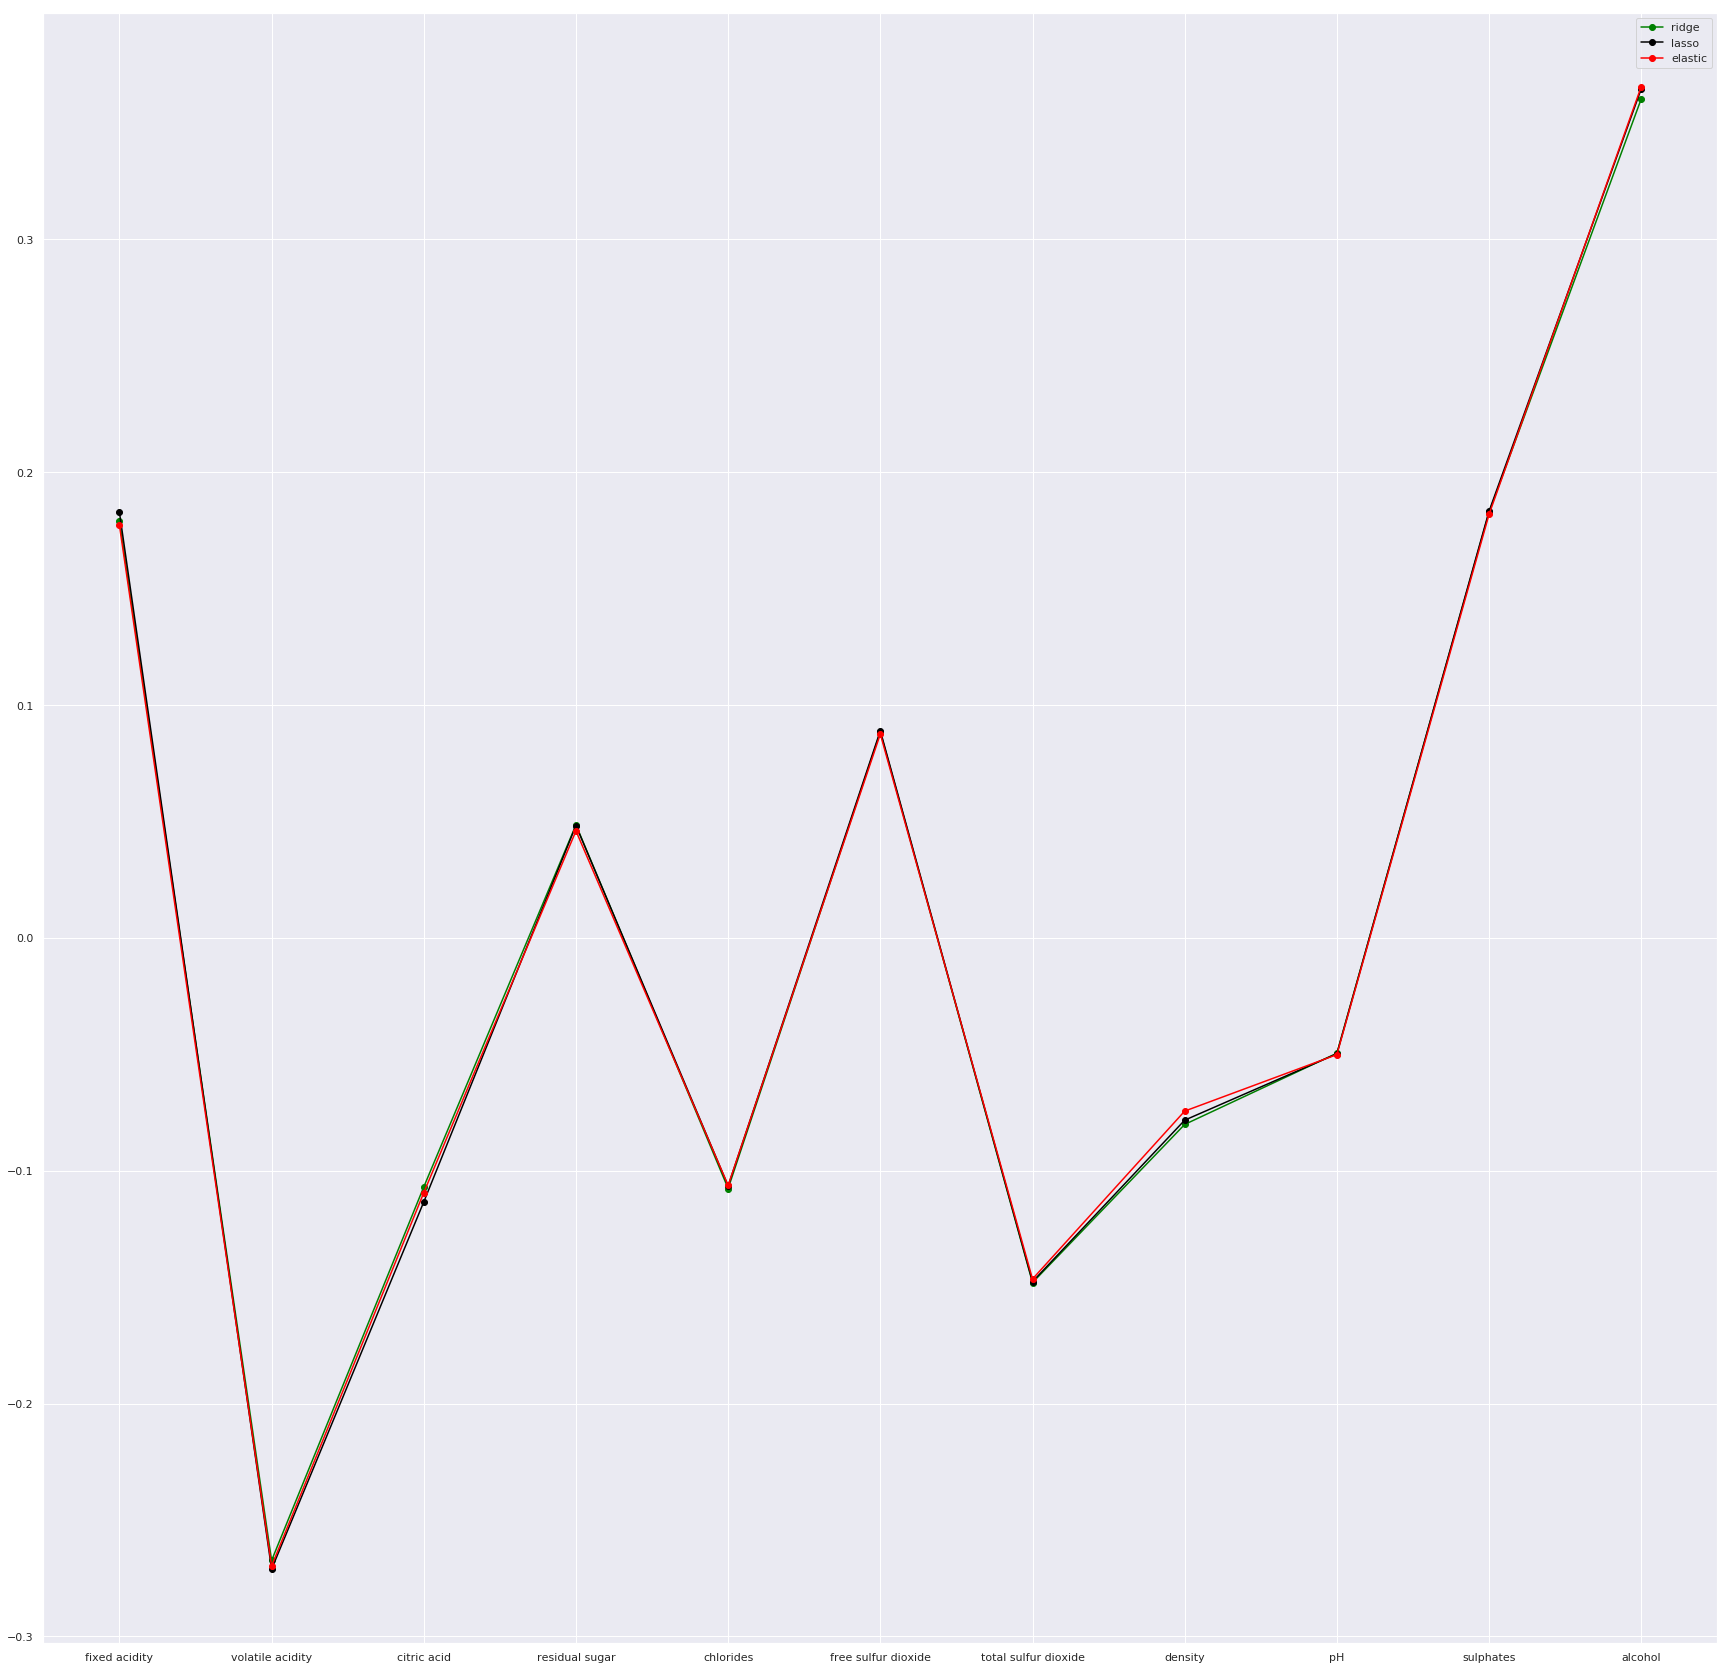

In [13]:
plt.plot(coefs_df['ridge'], 'o-', color='green')
plt.plot(coefs_df['lasso'], 'o-', color='black')
plt.plot(coefs_df['elastic'], 'o-', color='red')
plt.legend();

**La tendencia se mantiene en los 3 modelos.**

Hay una pequeña diferencia visualmente notable en:

- `density`
- `volatile acidity`
- `citric acid`

Los que están más cerca de 0:

- `citric acid`
- `free sulfur dioxide`